In [96]:
%matplotlib inline

In [97]:
from matplotlib import pyplot as plt
import numpy as np, os
from mantid import simpleapi as msa, mtd

Run # 130260, Vanadium 5x5cm2, Ei=55 meV, F2=420 Hz, T0=90 Hz, PC=3 C

Read data

In [98]:
w = msa.Load('/SNS/SEQ/IPTS-19573/nexus/SEQ_130260.nxs.h5', LoadMonitors=True)

In [99]:
mons = w[1]
w = w[0]

Get Ei, vi

In [100]:
Ei, T0 = msa.GetEiT0atSNS(mons)

In [101]:
Ei, T0

(55.46598187461831, 43.72705035409854)

In [102]:
vi = 437.4*np.sqrt(Ei)
vi

3257.5578083027858

Get L1, t1

In [8]:
instr = w.getInstrument()

In [9]:
print instr.getSource().getPos()
print instr.getSample().getPos()

[0,0,-20.0114]
[0,0,0]


In [10]:
L1 = (instr.getSample().getPos() - instr.getSource().getPos())[-1]

In [11]:
L1

20.0114

In [12]:
t1 = L1/vi*1e6
t1

6143.0682669684074

To histogram

In [13]:
msa.Rebin(InputWorkspace=w, OutputWorkspace=w, Params="0,1.,16667")

EventWorkspace
Title: Vanadium 5x5cm2, Ei=55meV F2=420 T0=90
Histograms: 115712
Bins: 16667
Histogram
X axis: Time-of-flight / microsecond
Y axis: Counts
Distribution: False
Instrument: SEQUOIA (2012-Apr-04 to 2100-Jan-31)Instrument from: /SNS/SEQ/IPTS-19573/nexus/SEQ_130260.nxs.h5

Parameters from: /home/lj7/dv/mantid/mantid/instrument/SEQUOIA_Parameters.xml
Run start: 2017-Jul-13 05:38:47
Run end:  2017-Jul-13 06:39:48

Events: 24081998

Nominal L2

In [14]:
L2 = np.linalg.norm(instr.getDetector(40000).getPos())
L2

5.5248554772882894

In [15]:
(L1+L2)/vi * 1e6 + T0

7882.8068088781329

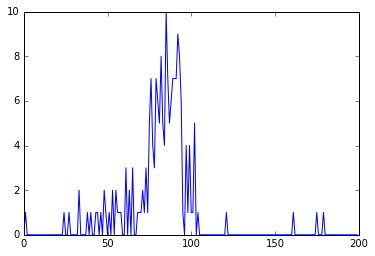

In [16]:
plt.plot(w.readY(40000)[7800:8000])

Simple estimate of peak position

In [17]:
t = np.argmax(w.readY(40000))
t

7885

In [18]:
t2 = t - t1 - T0
t2

1698.204682677494

In [19]:
d = t2*vi/1e6
d

5.5319999241524256

Pretty close

In [20]:
print d, L2

5.53199992415 5.52485547729


better estimate of peak position

In [21]:
tof_0 = (L1+L2)/vi * 1e6 + T0

In [22]:
print tof_0

7882.80680888


In [23]:
spectrum_number = 40000

In [24]:
spectrum = w.readY(spectrum_number)

In [25]:
center_bin = int(tof_0)

In [26]:
subset = spectrum[center_bin-100: center_bin+100]

In [27]:
center = np.dot(subset, np.arange(center_bin-100+.5, center_bin+100+.5))/np.sum(subset)

In [28]:
center

7881.2619047619046

In [29]:
t = center
print (t - t1 - T0)*vi/1e6, L2

5.51982286282 5.52485547729


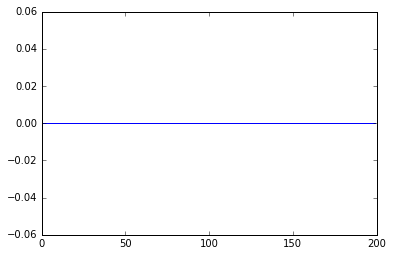

In [30]:
plt.plot(w.readY(0)[7800:8000])

In [60]:
N = w.getNumberHistograms()

In [88]:
def iterL2(min_counts=20):
    for i in range(N):
        if i%10000==0: print i
        sp = w.getSpectrum(i)
        pixelID = sp.getDetectorIDs()[0]
        spectrum = w.readY(i)
        nominal_L2 = np.linalg.norm(instr.getDetector(pixelID).getPos())
        tot_counts = np.sum(spectrum)
        if tot_counts == 0:
            yield i, pixelID, nominal_L2, -1, tot_counts # dets not installed
            continue
        nominal_TOF = (L1+nominal_L2)/vi * 1e6 + T0
        center_bin = int(nominal_TOF)
        subset = spectrum[center_bin-100: center_bin+100]
        center = np.dot(subset, np.arange(center_bin-100+.5, center_bin+100+.5))/np.sum(subset)
        t = center
        L2 = (t - t1 - T0)*vi/1e6
        # assert abs(nominal_L2-L2)/nominal_L2<0.1
        yield i, pixelID, nominal_L2, L2, tot_counts
        continue

In [89]:
%%time
L2s = list(iterL2(min_counts=1))

0
10000
20000
30000
40000
50000
60000


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


70000
80000
90000
100000
110000
CPU times: user 19.4 s, sys: 6.75 s, total: 26.1 s
Wall time: 26.1 s


In [91]:
for spectrumNo, pixelID, L2_0, L2, tot_counts in L2s:
    if L2 < 0: continue
    if L2 == 0 or abs(L2_0-L2)/L2_0 > 0.01:
        print spectrumNo, pixelID, L2_0, L2, tot_counts

24960 62848 5.69341562594 5.62806955291 246.0
24961 62849 5.69031016474 5.62960703057 189.0
24962 62850 5.6872184619 5.62538324799 144.0
24963 62851 5.68414053989 5.61798821733 157.0
24964 62852 5.68107642108 5.61851076316 168.0
24966 62854 5.67498968245 5.6046237205 176.0
24967 62855 5.67196710716 5.60686190138 169.0
24969 62857 5.66596365554 5.60406074486 177.0
24978 62866 5.63964051012 5.58259852632 164.0
62587 100475 5.53887524868 5.59877985922 1.0
62595 100483 5.51954885843 5.45490438936 7.0
62718 100606 5.5390762561 5.59552230141 1.0
62721 100609 5.5190508631 5.44078830552 2.0
63357 101245 5.53887265586 5.4733638836 2.0
63361 101249 5.51973256379 5.45870487347 1.0
63483 101371 5.53887524868 5.46033365237 2.0
63742 101630 5.53907625498 5.30885721428 1.0
63743 101631 5.53928058734 5.46684876799 2.0
64129 102017 5.51905086198 5.40006883292 1.0
64130 102018 5.51916315003 5.58249207018 1.0
64383 102271 5.53928058734 5.45870487347 2.0
64766 102654 5.51937184329 5.38378104387 1.0
65281 

In [95]:
L2s[:10]

[(0, 37888, 5.697820025621076, -1, 0.0),
 (1, 37889, 5.6947025850999067, -1, 0.0),
 (2, 37890, 5.6915988792577918, -1, 0.0),
 (3, 37891, 5.6885089305760568, -1, 0.0),
 (4, 37892, 5.6854327614851412, -1, 0.0),
 (5, 37893, 5.682370394363919, -1, 0.0),
 (6, 37894, 5.679321851539016, -1, 0.0),
 (7, 37895, 5.6762871552841263, -1, 0.0),
 (8, 37896, 5.6732663278193245, -1, 0.0),
 (9, 37897, 5.6702593913103794, -1, 0.0)]

In [114]:
L2table = msa.CreateEmptyTableWorkspace()

In [115]:
%%time
L2table.addColumn(type='int', name='detid')
L2table.addColumn(type='float', name="L2")
L2table.addColumn(type='int', name="nodata")

for spectrumNo, pixelID, L2_0, L2, tot_counts in L2s:
    row = dict(detid=pixelID, L2=L2, nodata=int(L2<0))
    L2table.addRow(row)

CPU times: user 540 ms, sys: 88 ms, total: 628 ms
Wall time: 565 ms


In [116]:
msa.SaveNexus(L2table, 'L2table.nxs')